## Firstly, let's import data ans set up need functions 

In [68]:
data_location = 'sqlite:///../../../data/data.db'

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [70]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [71]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [72]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [73]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [74]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


## Data Formatting

We import the function used during previous HW and results seems improving with !

In [75]:
def drawdown(df):
    peak = df['high'].cummax()
    gap_vs_peak = peak - df['low']
    max_drawdown = gap_vs_peak.cummax()
    return max_drawdown

In [76]:
tokens = ohlc.token.unique()
tokens

array(['BTC', 'ETH', 'USDT', 'SOL', 'ADA', 'DOT', 'AVAX', 'ATOM', 'CRV',
       'AAVE', 'COMP'], dtype=object)

In [77]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            dd = drawdown(df)
        )[['ts', 'vol', 'ret','dd']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret','dd'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

We create a memory of the last 6h in volatility and in returns : 

In [78]:
for token in tokens :
    X[f'return_6h_{token}']=(X[f'ret_{token}']).rolling(6).mean()
    X[f'vol_6h_{token}']=(X[f'vol_{token}']).rolling(6).mean()

In [79]:
X.tail()

,vol_BTC,ret_BTC,dd_BTC,vol_ETH,ret_ETH,dd_ETH,vol_USDT,ret_USDT,dd_USDT,vol_SOL,...,return_6h_AVAX,vol_6h_AVAX,return_6h_ATOM,vol_6h_ATOM,return_6h_CRV,vol_6h_CRV,return_6h_AAVE,vol_6h_AAVE,return_6h_COMP,vol_6h_COMP
ts,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,26667.0,0.158369,0.005961,1292.81,0.002463,0.0001,0.025,0.216740,...,-0.002307,0.226308,-0.002173,0.239803,-0.002988,0.255514,0.000192,0.191469,-0.004593,0.263387
2021-12-14 21:00:00,0.142237,0.019797,26667.0,0.170096,0.016737,1292.81,0.002652,0.0000,0.025,0.218492,...,-0.000385,0.230342,0.000502,0.244397,0.000061,0.255367,0.003321,0.200039,-0.003830,0.271155
2021-12-14 22:00:00,0.151148,0.010414,26667.0,0.172081,0.004623,1292.81,0.002684,0.0000,0.025,0.246122,...,0.005605,0.238851,0.003661,0.248707,0.006013,0.257241,0.005837,0.206283,0.000628,0.274657
2021-12-14 23:00:00,0.149424,-0.000302,26667.0,0.170257,-0.003195,1292.81,0.002823,0.0001,0.025,0.238235,...,0.010672,0.252972,0.001832,0.250306,0.003573,0.261020,0.004672,0.211553,0.000475,0.277878
2021-12-15 00:00:00,0.143079,-0.001448,26667.0,0.159883,-0.000641,1292.81,0.002816,0.0000,0.025,0.228867,...,0.013024,0.264060,0.001993,0.249361,0.004584,0.259686,0.005152,0.214920,0.003473,0.274062


We separate X and y variables ans get rid of the first 6 observations to have our mean :

In [80]:
y = X.ret_SOL.shift(-1)[6:-1]
X = X[6:-1]

In [81]:
X.shape

(1050, 55)

In [82]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

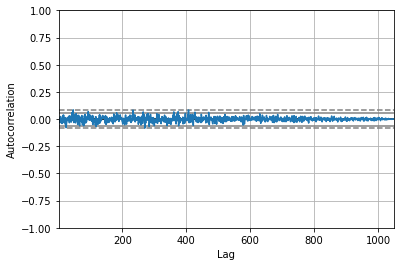

In [83]:
autocorrelation_plot(y[1:])

As seen in class, we do not have a strong autocorrelation.

In [84]:
{col: y.corr(X[col]) for col in X.columns if X[col].dtype != 'object'}

{'vol_BTC': 0.029724615398938288,
 'ret_BTC': -0.014424219219309933,
 'dd_BTC': -0.033620984217379225,
 'vol_ETH': 0.0249314726088943,
 'ret_ETH': 0.030489869525307953,
 'dd_ETH': -0.0368428414759475,
 'vol_USDT': 0.0071256549165129406,
 'ret_USDT': -0.04629384647184024,
 'dd_USDT': -0.04213987353937439,
 'vol_SOL': 0.036578281943385776,
 'ret_SOL': -0.03014677286267807,
 'dd_SOL': -0.026006038638417443,
 'vol_ADA': 0.04028574990601973,
 'ret_ADA': -0.0006875531162812079,
 'dd_ADA': -0.032928670774224816,
 'vol_DOT': 0.060850688157399135,
 'ret_DOT': 0.008614198716246912,
 'dd_DOT': -0.03418217937896658,
 'vol_AVAX': 0.0435288136100949,
 'ret_AVAX': 0.0161548595917745,
 'dd_AVAX': -0.033487771112617123,
 'vol_ATOM': -0.0015038469754492152,
 'ret_ATOM': 0.05370589354217922,
 'dd_ATOM': -0.03399733390690427,
 'vol_CRV': 0.021139109616167825,
 'ret_CRV': -0.009301375921279937,
 'dd_CRV': -0.03679647666589197,
 'vol_AAVE': 0.03732673752793822,
 'ret_AAVE': 0.01944369225891374,
 'dd_AAVE': 

## Find the better model

In [85]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [86]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [87]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size)-3, test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [88]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

In [89]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 2, 3,4,5, 7,10, 20, 30, 40, 50],
    'model__alpha': [0.01,0.033,0.066,0.1, 0.33, 0.66, 1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=210, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA()), ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.01, 0.033, 0.066, 0.1, 0.33, 0.66,
                                          1.0],
                         'pca__n_components': [1, 2, 3, 4, 5, 7, 10, 20, 30, 40,
                                               50]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [90]:
search.best_params_

{'model__alpha': 0.01, 'pca__n_components': 3}

In [91]:
best_model = search.best_estimator_

In [92]:
evaluate_model(best_model, X, y)

-0.00843374324207387

<module 'matplotlib.pyplot' from 'C:\\Users\\basti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

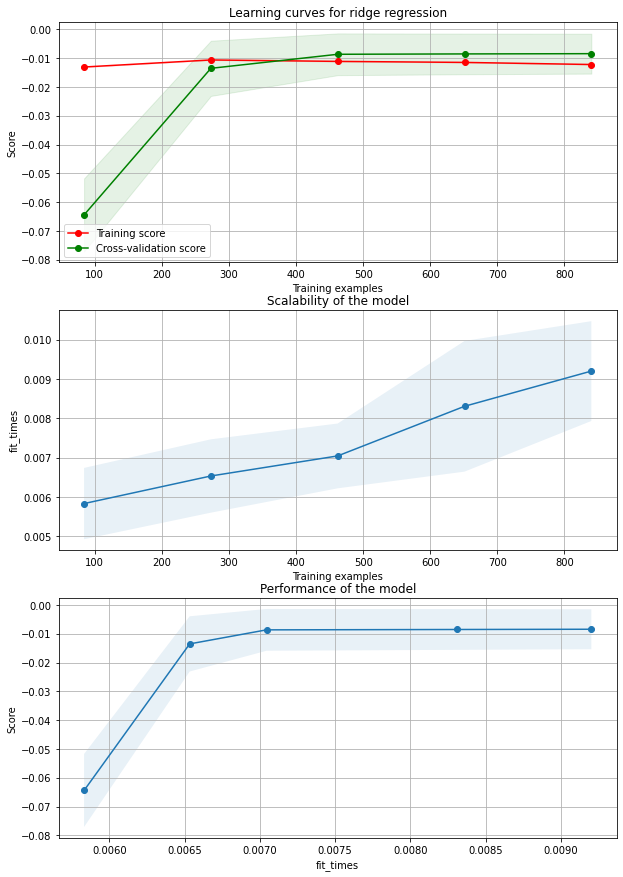

In [93]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)

## Save the model

In [94]:
pickle.dump(best_model, open('best_model.pkl', 'wb'))

In [95]:
loaded_model = pickle.load(open('best_model.pkl', 'rb'))

In [96]:
evaluate_model(loaded_model, X, y)

-0.008433743241924448